### Dataset

In [21]:
import pandas as pd
from datasets import Dataset

df1 = pd.read_json('detection_dataset_1st_iter.jsonl', lines=True)
df2 = pd.read_json('detection_dataset_2nd_iter.jsonl', lines=True)

combined_df = pd.concat([df1, df2], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)

In [2]:
import numpy as np
import evaluate
from sklearn.metrics import fbeta_score

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions, references=labels, average='weighted')["precision"],
        "recall": recall.compute(predictions=predictions, references=labels, average='weighted')["recall"],
        "f1": f1.compute(predictions=predictions, references=labels, average='weighted')["f1"],
        "f2": fbeta_score(labels, predictions, beta=2, average="weighted")
    }

In [3]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

d:\Zuza\MAGISTERKA\AI-Generated-CTI\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakub\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "REAL", 1: "GENERATED"}
label2id = {"REAL": 0, "GENERATED": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from datasets import ClassLabel

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

label_feature = ClassLabel(names=["0", "1"])
tokenized_data = tokenized_data.cast_column("label", label_feature)

tokenized_data = tokenized_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
training_eval_tokenized_data = tokenized_data['train'].train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1034 [00:00<?, ? examples/s]

In [ ]:
from collections import Counter

print("Train:", Counter(training_eval_tokenized_data["train"]["label"]))
print("Validation:", Counter(training_eval_tokenized_data["test"]["label"]))
print("Test:", Counter(tokenized_data["test"]["label"]))

Train: Counter({0: 372, 1: 372})
Validation: Counter({0: 42, 1: 41})
Test: Counter({1: 104, 0: 103})


### Training

In [16]:
from transformers import TrainingArguments, Trainer

trainer = Trainer(
    model=model,
    train_dataset=training_eval_tokenized_data['train'],
    eval_dataset=training_eval_tokenized_data['test'],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    args=TrainingArguments(
        output_dir="results_distilbert",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_steps=10,
        eval_steps=10,
        eval_strategy="steps",
        load_best_model_at_end=True,
        report_to="none"
    ),
)

trainer.train()

finetuned_model = "distilbert-finetuned"
model.save_pretrained(finetuned_model)
tokenizer.save_pretrained(finetuned_model)

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F2
10,0.677500,0.630859,0.771084,0.826456,0.771084,0.761697,0.759650
20,0.576400,0.494646,0.951807,0.955998,0.951807,0.951667,0.951220
30,0.425100,0.311138,0.975904,0.975904,0.975904,0.975904,0.975904
40,0.270300,0.184049,0.975904,0.975904,0.975904,0.975904,0.975904
50,0.141700,0.106515,0.987952,0.988232,0.987952,0.987948,0.987916
60,0.087900,0.063857,1.000000,1.000000,1.000000,1.000000,1.000000
70,0.059700,0.044776,1.000000,1.000000,1.000000,1.000000,1.000000
80,0.044200,0.036160,1.000000,1.000000,1.000000,1.000000,1.000000
90,0.037900,0.032955,1.000000,1.000000,1.000000,1.000000,1.000000


('distilbert-finetuned\\tokenizer_config.json',
 'distilbert-finetuned\\special_tokens_map.json',
 'distilbert-finetuned\\vocab.txt',
 'distilbert-finetuned\\added_tokens.json',
 'distilbert-finetuned\\tokenizer.json')

### Evaluation

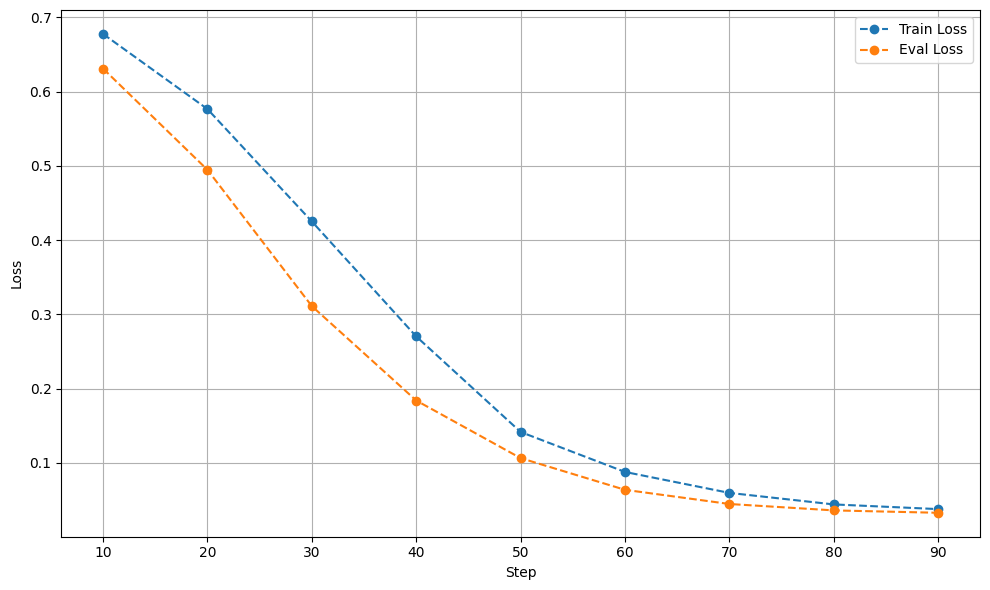

In [17]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log and "eval_loss" not in log]
train_losses = [log["loss"] for log in logs if "loss" in log and "eval_loss" not in log]

eval_steps = [log["step"] for log in logs if "eval_loss" in log]
eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,6))
plt.plot(train_steps, train_losses, label="Train Loss", marker='o', linestyle='--')
plt.plot(eval_steps, eval_losses, label="Eval Loss", marker='o', linestyle='--')

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("detector_train_eval_loss.svg")
plt.show()

Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'f2': 1.0}


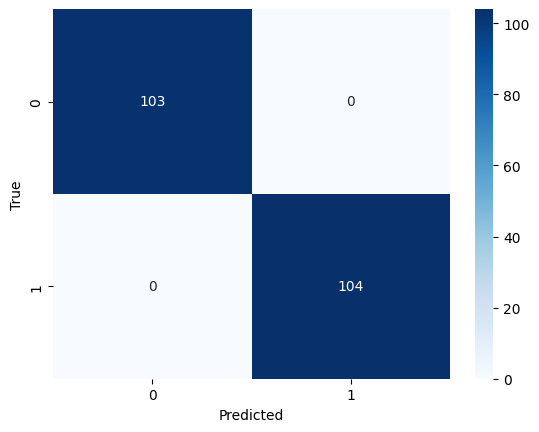

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = evaluate.load("confusion_matrix")

pred_output = trainer.predict(tokenized_data["test"])
predictions = pred_output.predictions
labels = pred_output.label_ids

print("Metrics:", compute_metrics((predictions, labels)))

results = conf_matrix.compute(predictions=np.argmax(predictions, axis=1), references=labels)
cm = np.array(results["confusion_matrix"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.svg")
plt.show()

In [20]:
idx = 0

text = tokenized_data["test"][idx]["text"]
print(text)

example = tokenized_data["test"].select([idx])
prediction = trainer.predict(example)

predicted_label = np.argmax(prediction.predictions, axis=1)[0]
true_label = tokenized_data["test"][idx]["label"]
label_map = {0: "REAL", 1: "GENERATED"}
print(f"Predicted: {label_map[predicted_label]} vs. True: {label_map[true_label]}")

SAF-T Framework Transaction SAFTN_G is a transaction that allows an attacker to perform a specific action on a target system. This transaction is used by malware to gain access to the targeted system.


Predicted: GENERATED vs. True: GENERATED
